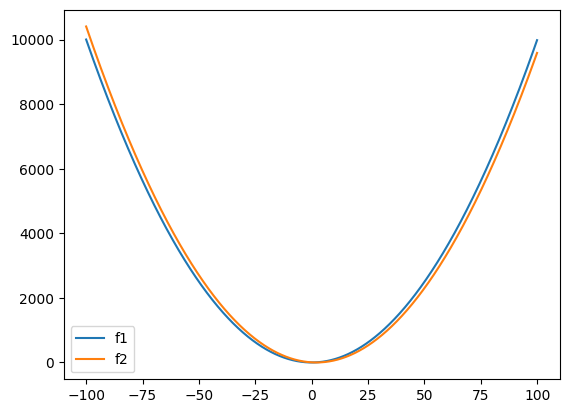

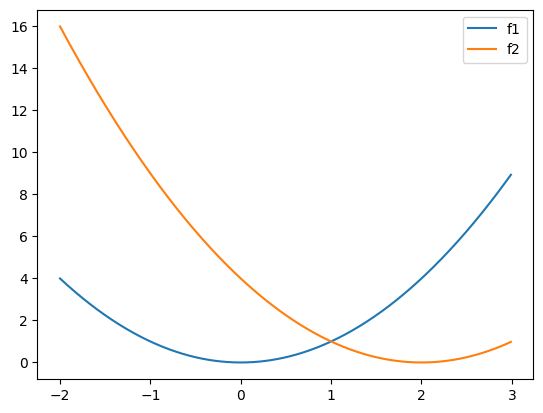

In [1]:
# Problem description
from matplotlib import pyplot as plt
import numpy as np

bounds = [(-100, 100)]

def objf(x):
    return [[xi[0]**2, (xi[0]-2)**2] for xi in x]

x = np.arange(-100, 100, 0.1)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

x = np.arange(-2, 3, 0.01)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label='f1')
plt.plot(x, f2x, label='f2')
plt.legend()
plt.show()

In [2]:
from blackboxopt.rbf import RbfModel
from blackboxopt.acquisition import UniformAcquisition, CoordinatePerturbation
from blackboxopt.sampling import NormalSampler

maxeval = 100
ncand = 500
sigma = 0.02
reltol = 0.05
tol = 0.001 * (bounds[0][1] - bounds[0][0])

localAcquisition = CoordinatePerturbation(maxeval, NormalSampler(ncand,sigma), weightpattern=(0.95,), reltol=reltol)
globalAcquisition = UniformAcquisition(ncand, 0.95, tol)

In [3]:
from blackboxopt.optimize import socemo

surrogateModels = [RbfModel(), RbfModel()]
res = socemo(objf, bounds, maxeval, surrogateModels=surrogateModels, acquisitionFunc=localAcquisition, acquisitionFuncGlobal=globalAcquisition, disp=True)

Iteration: 0
fEvals: 4
Time to update surrogate model: 0.000383 s
Fill gaps in the Pareto front: 0.000001 s
Random perturbation of the currently nondominated points: 0.001033 s
Minimum point sampling: 0.000001 s
Uniform random points and scoring: 0.004098 s
Solving the surrogate multiobjective problem: 1.504923 s
Number of new samples:  3
Iteration: 1
fEvals: 7
Time to update surrogate model: 0.000451 s
Fill gaps in the Pareto front: 0.000001 s
Random perturbation of the currently nondominated points: 0.000387 s
Minimum point sampling: 0.000000 s
Uniform random points and scoring: 0.000254 s
Solving the surrogate multiobjective problem: 1.086708 s
Number of new samples:  4
Iteration: 2
fEvals: 11
Time to update surrogate model: 0.000289 s
Fill gaps in the Pareto front: 0.000001 s
Random perturbation of the currently nondominated points: 0.000547 s
Minimum point sampling: 0.000001 s
Uniform random points and scoring: 0.000298 s
Solving the surrogate multiobjective problem: 1.142937 s
Nu

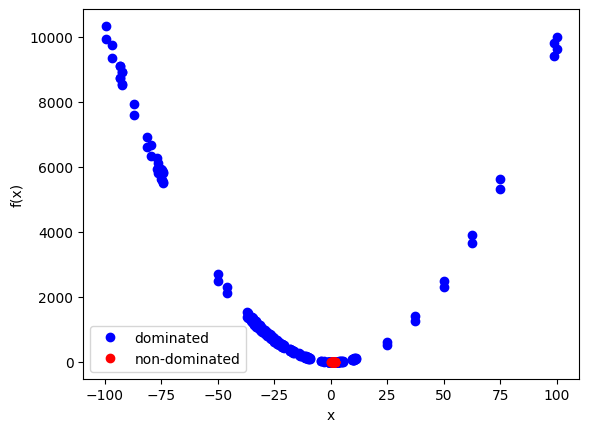

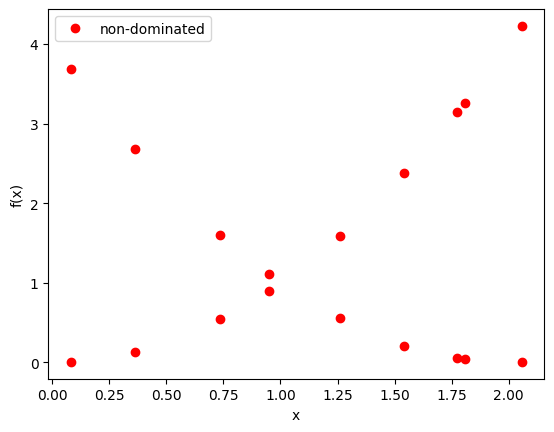

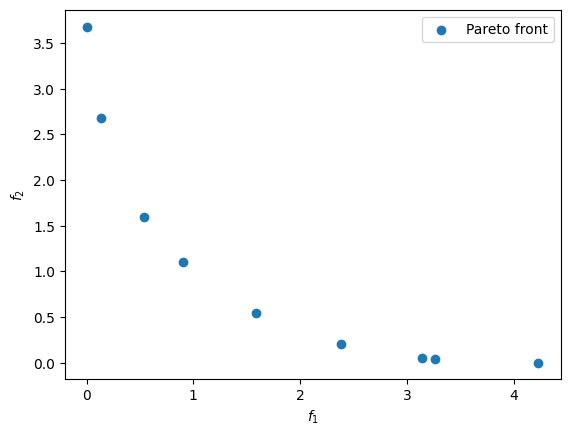

In [4]:
from matplotlib import pyplot as plt

samples = res.samples.flatten()
f1 = res.fsamples[:,0].flatten()
f2 = res.fsamples[:,1].flatten()
nondominated = res.x
paretoFront = res.fx

plt.plot(samples, f1, 'bo', label="dominated")
plt.plot(samples, f2, 'bo')
plt.plot(nondominated, paretoFront[:,0], 'ro', label="non-dominated")
plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

plt.plot(nondominated, paretoFront[:,0], 'ro', label="non-dominated")
plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

# plt.scatter(res.fsamples[:, 0], res.fsamples[:, 1], label="Samples")
plt.scatter(res.fx[:, 0], res.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()

In [5]:
res.fx

array([[3.26296017e+00, 3.74939066e-02],
       [1.58478579e+00, 5.49254774e-01],
       [4.22865419e+00, 3.17748394e-03],
       [6.61692959e-03, 3.68123888e+00],
       [1.32584684e-01, 2.67609749e+00],
       [5.39788059e-01, 1.60097726e+00],
       [8.99758782e-01, 1.10553416e+00],
       [3.14463333e+00, 5.13877202e-02],
       [2.38016080e+00, 2.09052894e-01]])